# Домашнее задание к занятию 2.1: Деревья решений. Классификация

## Обзор прошедшего занятия

Что мы делали в классе:

**Задание 1**
* строили деревья
* критерии информативности которых написали даже сами
* визуализировали границы принятия решений в 2d
* и рисовали сами деревья


**Задание 2**
* приняли участие в соревновании на Kaggle, переварив кучу текстовых фичей в численные, проведя кросс-валидацию и сделав сабмит


**Задание 3**
* построили руками несколько метрик качества бинарной классификации


**Задание 4**
* использовали их для оценки классификации разделения статей Ведомостей по топикам

*дополнительно было много приятных ништяков. Например, облако слов, мультипоточность в целях парсинга, удобный инструмент для нахождения правильной css разметки, сохранение моделей в статичные файлы, разделение строк на слова и лемматизация этих слов*

## Домашнее задание

**Lvl 1:**

* взять подготовленные раннее данные из задачи **Titanic**, обучиться на них с помощью дерева решений и кросс-валидации и сделать сабмит
* кросс-валидацию желательно сделать сразу по нескольким фичам ( параметр *grid* в *GridSearchCV* )
* определить самые важные фичи
* вывести дерево решений (можете попробовать установить pydot и webgraphviz для отрисовки деревьев внутри ноутбука)

**Результат:** скрины нового сабмита на Kaggle и построенного дерева

**Lvl 2:** (опционально)

* С помощью функций sklearn.metrics.auc, precision, recall составить функцию для расчёта ROC-AUC, ROC-PRC
* Придумать себе интересную задачу на основе данных из интернета =) Спарсить ещё какой-нибудь сайт (не Ведомости) и решить задачу классификации. Делать свои проекты - круто. Если будут - кидайте мне =) [@NikitaKuznetsov](http://t.me/NikitaKuznesov)

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, make_scorer

%config InlineBackend.figure_format = 'svg'
from pylab import rcParams
rcParams['figure.figsize'] = (9, 6)

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [2]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [6]:
y = train.Survived
train.drop('Survived', axis=1, inplace=True)

In [7]:
train.columns == test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [8]:
train['is_test'] = 0
test['is_test'] = 1

In [9]:
df = pd.concat([train, test])

In [10]:
df["isMale"] = df.Sex.replace({"male": 1, "female":0})

In [11]:
df.loc[ df['Age'] <= 16, 'Age'] = 0
df.loc[(df['Age'] > 16) & (df['Age'] <= 32), 'Age'] = 1
df.loc[(df['Age'] > 32) & (df['Age'] <= 48), 'Age'] = 2
df.loc[(df['Age'] > 48) & (df['Age'] <= 64), 'Age'] = 3
df.loc[ df['Age'] > 64, 'Age']

33     66.0
54     65.0
96     71.0
116    70.5
280    65.0
456    65.0
493    71.0
630    80.0
672    70.0
745    70.0
851    74.0
81     67.0
96     76.0
Name: Age, dtype: float64

In [12]:
df_dummies = pd.get_dummies(df, columns=['Pclass', 'Embarked'])

In [13]:
X_train = df_dummies[df_dummies.is_test==0].drop(['is_test', 'Sex', 'PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
X_test = df_dummies[df_dummies.is_test==1].drop(['is_test', 'Sex', 'PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

In [14]:
columns = X_train.columns

In [15]:
from sklearn.preprocessing import Imputer

imputer = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=0, copy=True)

imputer.fit(X_train)

X_train_imputed = imputer.transform(X_train)
X_train_imputed = pd.DataFrame(X_train_imputed, columns=columns)

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_train_imputed)

X_train_imputed_scaled = scaler.transform(X_train_imputed)
X_train_imputed_scaled = pd.DataFrame(X_train_imputed_scaled, columns=columns)

In [17]:
X_test_imputed_scaled = scaler.transform(imputer.transform(X_test))

In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_imputed_scaled, y, test_size=0.2)

# clf = DecisionTreeClassifier(max_depth=5, min_samples_split=0.2,
#                              min_samples_leaf=0.01, max_features=0.835)

clf = DecisionTreeClassifier()

clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [52]:
%%time
from sklearn.model_selection import GridSearchCV
clf_parameters = {
    'max_features': np.linspace(0.01, 1, 25),
    'max_depth': np.arange(1,10),
    'min_samples_split': np.linspace(0.1, 1, 20),
    'min_samples_leaf': np.linspace(0.01, 0.5, 20)
}

grid_clf = GridSearchCV(
    estimator=clf,
    param_grid=clf_parameters,
    scoring=make_scorer(roc_auc_score),
    n_jobs=-1,
    cv=3,
    iid=True,
    return_train_score=True
)


grid_clf.fit(X_train_imputed_scaled, y)

Wall time: 3min 26s


In [53]:
grid_clf.best_params_, grid_clf.best_score_

({'max_depth': 9,
  'max_features': 0.7937500000000001,
  'min_samples_leaf': 0.01,
  'min_samples_split': 0.1},
 0.7868133448375035)

In [54]:
max_depth = grid_clf.best_params_['max_depth']
max_features = grid_clf.best_params_['max_features']
min_samples_leaf = grid_clf.best_params_['min_samples_leaf']
min_samples_split = grid_clf.best_params_['min_samples_split']

In [55]:
clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split,
                             min_samples_leaf=min_samples_leaf, max_features=max_features)

clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features=0.7937500000000001, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.01, min_samples_split=0.1,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [56]:
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

In [57]:
print("Train: ", roc_auc_score(y_test_predict, y_test))

Train:  0.7983181692859112


In [58]:
accuracy_score(y_test, y_test_predict)

0.8156424581005587

In [59]:
predictions = clf.predict(X_test_imputed_scaled)
predictions

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

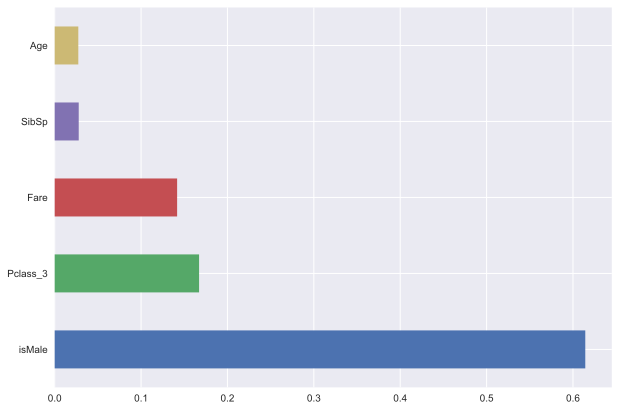

In [60]:
sns.set()
IDcol = 'PassengerId'
y_label = 'label'
predictors = [x for x in columns if x not in [y_label, IDcol]]
plt.figure(figsize=(10,7))
(pd.Series(clf.feature_importances_, predictors).sort_values(ascending=False))[:5].plot(kind='barh')

In [61]:
for col, val in zip(X_train.columns, clf.feature_importances_):
    print("{:30} {:.5f}".format(col, val))

Age                            0.02735
SibSp                          0.02783
Parch                          0.02009
Fare                           0.14173
isMale                         0.61423
Pclass_1                       0.00000
Pclass_2                       0.00000
Pclass_3                       0.16715
Embarked_C                     0.00000
Embarked_Q                     0.00000
Embarked_S                     0.00163


In [41]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(clf, out_file='tree.dot',
                feature_names = columns,
                class_names = ['survived',"didn't survive"],
                rounded = True, proportion = False,
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)

from subprocess import call, check_call
call('dot -Tpng tree.dot -o tree.png -Gdpi=600', shell=True)

# # Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

In [62]:
submussion = 'PassengerId,Survived\n'
submussion += "\n".join(["{},{}".format(pid, prediction) for pid, prediction in zip(test.PassengerId, predictions)])

with open('submission.csv', 'w') as file:
    file.write(submussion)